В этом файле создается модель бинарной классификации - "является ли инструмент, звучащий в файле скрипкой?"

Для начала подготовим данные: разделим каждый аудиофайл на сегменты определенной длительности - 1 секунда, сгенерируем спектрограмму для каждого сегмента и сохраним их в формате, подходящим для обучения

In [9]:
def split_audio_to_segments(file_path, segment_duration=1.0, overlap=0.5):
    y, sr = librosa.load(file_path, sr=22050)
    segment_samples = int(segment_duration * sr)
    step = int(segment_samples * (1 - overlap))
    
    segments = []
    for start in range(0, len(y) - segment_samples, step):
        segment = y[start:start + segment_samples]
        segments.append(segment)
    
    return segments

def augment_audio_segment(segment, sr=22050):
    augmented = []
    
    # 1. Добавление шума
    noise = 0.005 * np.random.randn(len(segment))
    augmented.append(segment + noise)
    
    # 2. Изменение высоты тона
    augmented.append(librosa.effects.pitch_shift(segment, sr=sr, n_steps=2))
    augmented.append(librosa.effects.pitch_shift(segment, sr=sr, n_steps=-2))
    
    # 3. Изменение темпа
    augmented.append(librosa.effects.time_stretch(segment, rate=0.8))
    augmented.append(librosa.effects.time_stretch(segment, rate=1.2))
    
    return augmented

In [1]:
import librosa
import soundfile as sf
import os

def split_wav(input_path, output_dir, segment_length=3, overlap=0.1):
    y, sr = librosa.load(input_path, sr=None)
    segment_samples = int(segment_length * sr)
    step = int(segment_samples * (1 - overlap))
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i, start in enumerate(range(0, len(y), step)):
        end = start + segment_samples
        segment = y[start:end]
        if len(segment) < segment_samples:
            continue  # Пропускаем последний неполный фрагмент
        sf.write(f"{output_dir}/{os.path.basename(input_path)}_{i}.wav", 
                segment, sr)
   
wav_folder = 'lettersabc/a/balanced_instruments/no_pauses/valid/wav'
     
for root, dirs, files in os.walk(wav_folder):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            split_wav(file_path, wav_folder)

Здесь необходимо поправить названия файлов чтобы последующий код работал корректно

In [ ]:
# import os

# # Путь к папке с файлами
# wav_folder = 'lettersabc/a/balanced_instruments/no_pauses/valid/wav'

# for filename in os.listdir(wav_folder):
#     if filename.endswith('.wav'):
#         # Обработка названия файла
#         if '_no_pauses.wav_' in filename:
#             # Удаляем "_no_pauses.wav_" и оставляем только номер
#             new_name = filename.replace('_no_pauses.wav_', '_')
#         elif filename.endswith('_no_pauses.wav'):
#             # Для файлов без номера просто удаляем "_no_pauses"
#             new_name = filename.replace('_no_pauses.wav', '.wav')
#         else:
#             # Если не наш шаблон - пропускаем файл
#             continue
        
#         # Переименовываем только Violin в Скрипка
#         if new_name.startswith('Violin_'):
#             new_name = new_name.replace('Violin_', 'Скрипка_')
        
#         # Полные пути к файлам
#         old_path = os.path.join(wav_folder, filename)
#         new_path = os.path.join(wav_folder, new_name)
        
#         # Переименовываем файл
#         try:
#             os.rename(old_path, new_path)
#             print(f"Переименован: {filename} -> {new_name}")
#         except FileExistsError:
#             # Если файл уже существует, пропускаем
#             print(f"Файл {new_name} уже существует, пропускаем")
#         except Exception as e:
#             print(f"Ошибка при переименовании {filename}: {str(e)}")

Переименован: Acoustic Guitar _steel__no_pauses.wav -> Acoustic Guitar _steel_.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_0.wav -> Acoustic Guitar _steel__0.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_1.wav -> Acoustic Guitar _steel__1.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_10.wav -> Acoustic Guitar _steel__10.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_100.wav -> Acoustic Guitar _steel__100.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_101.wav -> Acoustic Guitar _steel__101.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_102.wav -> Acoustic Guitar _steel__102.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_103.wav -> Acoustic Guitar _steel__103.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_104.wav -> Acoustic Guitar _steel__104.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_105.wav -> Acoustic Guitar _steel__105.wav
Переименован: Acoustic Guitar _steel__no_pauses.wav_106.wav -> Acoustic 

In [6]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import joblib

wav_folder = 'lettersabc/a/balanced_instruments/no_pauses/valid/wav'
output_dir = "preprocessed_data"
segment_duration = 1.0
max_duration_per_instrument = 5 * 60
# Здесь используем частоту дискретизации в 22050 Гц, чтобы ограничить размер спектрограмм без потери качества распознавания модели
target_sr = 22050
n_mels = 128
img_height, img_width = n_mels, 128

os.makedirs(output_dir, exist_ok=True)

# Создаем спектрограммы для сегментов
# def process_audio_file(file_path, label, max_segments=None):
#     try:
#         y, sr = librosa.load(file_path, sr=target_sr)
#     except Exception as e:
#         print(f"Error loading {file_path}: {e}")
#         return []
    
#     duration = librosa.get_duration(y=y, sr=sr)
#     segment_samples = int(segment_duration * sr)
#     total_samples = len(y)
        
#     if max_segments is not None:
#         max_total_samples = int(max_segments * segment_duration * sr)
#         if total_samples > max_total_samples:
#             y = y[:max_total_samples]
#             total_samples = len(y)
    
#     # Разделяем на сегменты
#     result = []
#     segments = split_audio_to_segments(y, segment_duration=1.0, overlap=0.5)
#     for start in range(0, total_samples, segment_samples):
#         end = start + segment_samples
#         if end > total_samples:
#             break
#         segment = y[start:end]
        
#         spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels)
#         spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
#         # Нормализуем
#         spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
#         # segments.append((spectrogram_db, label))
        
#         result.append((spectrogram_db, label))
        
#         if label == 1:
#             for aug_segment in augment_audio_segment(segment, sr):
#                 spectrogram = librosa.feature.melspectrogram(y=aug_segment, sr=sr)
#                 spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
#                 result.append((spectrogram_db, label))
    
#     return result


def process_audio_file(file_path, label, max_segments=None):
    try:
        y, sr = librosa.load(file_path, sr=22050)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []
    
    # Получаем длительность в секундах
    duration = librosa.get_duration(y=y, sr=sr)
    segment_samples = int(segment_duration * sr)
    
    # Создаем сегменты без перекрытия (для начала)
    segments = []
    for start in range(0, len(y), segment_samples):
        end = start + segment_samples
        if end > len(y):
            break
        segment = y[start:end]
        
        # Создаем спектрограмму
        S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
        S_db = librosa.power_to_db(S, ref=np.max)
        
        segments.append((S_db, label))
    
    # Ограничиваем количество сегментов если нужно
    if max_segments is not None:
        segments = segments[:max_segments]
    
    return segments

Подготовим датасет, а именно - обработаем файлы, создадим спектрограммы и метки для дальнейшего обучения

In [ ]:
def prepare_dataset(file_list, violin_class="скрипка", violin_multiplier=3):
    class0_segments = []
    class1_segments = []
    
    for file_path in file_list:
        file = os.path.basename(file_path)
        label = 1 if violin_class in file.lower() else 0
        
        segments = process_audio_file(file_path, label)
        
        if label == 1:
            class1_segments.extend(segments)
        else:
            class0_segments.extend(segments)
    
    max_other = len(class1_segments) * 2  # Соотношение 1:2
    class0_segments = class0_segments[:max_other]
    
    all_segments = class0_segments + class1_segments
    np.random.shuffle(all_segments)
    
    X = np.array([s[0] for s in all_segments])
    y = np.array([s[1] for s in all_segments])
    return X[..., np.newaxis], y


Создаём CNN-модель. Используем 4 сверточных блока. 
Входной слой - (128, 44, 1) - 128 мел-бандов, 44 временных шага и 1 канал.
Conv2D - извлекает локальные признаки
BatchNorm - нормализация
MaxPooling - уменьшает размерность в 2 раза, сохраняя важные признаки
Flatten - разворачивает 3D-тензор в 1D для полносвязных слоев
Dense - полносвязный слой для комбинирования признаков
Dropout - регуляризация
Dense - финальный классификатор, вероятность 1 класса

In [3]:
# def create_cnn_model(input_shape):
#     model = models.Sequential([
#         layers.Input(shape=input_shape),
        
#         # Первый сверточный блок
#         layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         # Второй сверточный блок
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         # Третий сверточный блок
#         layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         # Четвертый сверточный блок
#         layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
        
#         # Классификатор
#         layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(0.5),
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy', 'AUC'])
    
#     return model

def create_cnn_model(input_shape):
    """Модифицированная модель с акцентом на особенности скрипки"""
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # Увеличенное количество фильтров в первых слоях
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Слой с увеличенным рецептивным полем для характерных скрипичных звуков
        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Глобальное усреднение вместо Flatten для лучшей обобщающей способности
        layers.GlobalAveragePooling2D(),
        
        # Упрощенный классификатор с регуляризацией
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Оптимизатор с меньшим learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', tf.keras.metrics.Recall()]
    )
    
    return model

# def create_cnn_model(input_shape):
#     model = models.Sequential([
#         layers.Input(shape=input_shape),
        
#         # Базовый блок
#         layers.Conv2D(32, (3, 3), activation='relu'),
#         layers.MaxPooling2D((2, 2)),
        
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.MaxPooling2D((2, 2)),
        
#         layers.Flatten(),
#         layers.Dense(64, activation='relu'),
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer='adam',
#                 loss='binary_crossentropy',
#                 metrics=['accuracy', 'AUC'])
#     return model

Обучаем модель CNN
EarlyStopping - останавливает обучение, если val_loss не улучшается 10 эпох подряд и восстанавливает лучшие веса
ModelCheckpoint - сохраняет модель с лучшим val_loss в файл best_model.h5

In [4]:
def train_model(X_train, y_train, X_val, y_val, input_shape):

    model = create_cnn_model(input_shape)
    model.summary()
    
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
    
    # class_weight = {0: 1, 1: 10}
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        # class_weight=class_weight
    )
    
    return model, history


Используем все функции

Поиск файлов в lettersabc/a/balanced_instruments/no_pauses/valid/wav...
Найдено файлов: 20450
Распределение классов: {0: 20333, 1: 117}

Обработка тренировочных данных...
Получено тренировочных сэмплов: 6132

Обработка тестовых данных...
Получено тестовых сэмплов: 3069

Балансировка данных...
До балансировки - класс 0: 5850 класс 1: 282
После балансировки - класс 0: 5850 класс 1: 5850
Место на диске: 9 GB свободно

Данные сохранены в output\processed_data.joblib

Финальные размеры данных:
Train: (8775, 128, 44, 1) (8775,)
Validation: (2925, 128, 44, 1) (2925,)
Test: (3069, 128, 44, 1) (3069,)
Баланс классов в train: (array([0, 1]), array([4387, 4388], dtype=int64))

Обучение модели...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 44, 64)       640       
                                                                 
 batch_normalization

c:\Users\E8904\Documents\University\4course\diploma\new_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 400s 1s/step - loss: 0.0243 - accuracy: 0.9941 - auc: 0.9989 - recall_1: 0.9982 - val_loss: 0.0177 - val_accuracy: 0.9973 - val_auc: 0.9994 - val_recall_1: 1.0000
Epoch 3/50
275/275 [==============================] - 392s 1s/step - loss: 0.0168 - accuracy: 0.9969 - auc: 0.9991 - recall_1: 0.9993 - val_loss: 0.0309 - val_accuracy: 0.9942 - val_auc: 0.9983 - val_recall_1: 0.9945
Epoch 4/50
275/275 [==============================] - 393s 1s/step - loss: 0.0152 - accuracy: 0.9967 - auc: 0.9994 - recall_1: 0.9993 - val_loss: 0.0148 - val_accuracy: 0.9966 - val_auc: 0.9992 - val_recall_1: 1.0000
Epoch 5/50
275/275 [==============================] - 394s 1s/step - loss: 0.0102 - accuracy: 0.9976 - auc: 0.9998 - recall_1: 0.9993 - val_loss: 0.0164 - val_accuracy: 0.9959 - val_auc: 0.9983 - val_recall_1: 1.0000
Epoch 6/50
275/275 [==============================] - 486s 2s/step - loss: 0.0099 - accuracy: 0.9974 - auc: 0.9998 - recall_1: 0.9993 - val_los

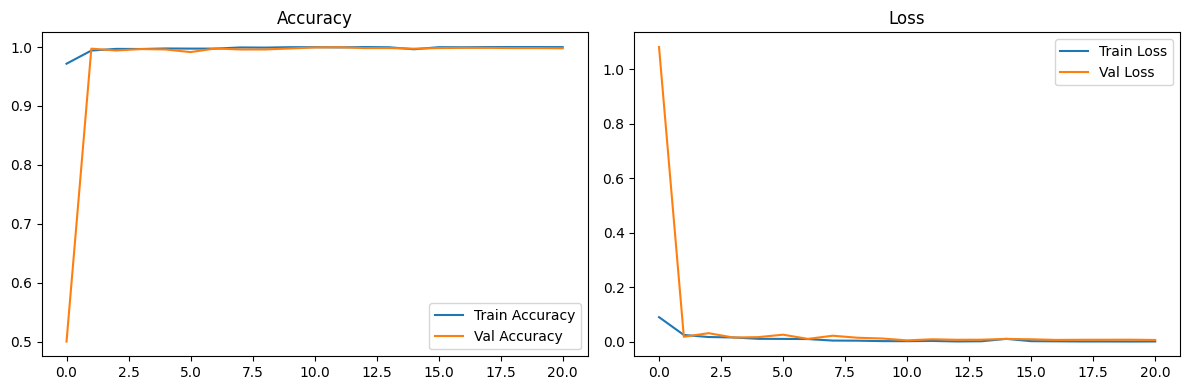

Модель сохранена в output\violin_model.h5


c:\Users\E8904\Documents\University\4course\diploma\new_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:

import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import AUC
import tensorflow as tf
import shutil

def balance_samples(X, y):
    """Балансировка на уровне сэмплов"""
    if len(X) == 0 or len(y) == 0:
        raise ValueError("Пустые данные для балансировки")
    
    X = np.array(X)
    y = np.array(y)
    
    class0_idx = np.where(y == 0)[0]
    class1_idx = np.where(y == 1)[0]
    
    if len(class0_idx) == 0 or len(class1_idx) == 0:
        raise ValueError("Один из классов отсутствует в данных")
    
    max_samples = max(len(class0_idx), len(class1_idx))
    
    if len(class0_idx) < max_samples:
        resampled_idx = resample(class0_idx, replace=True, n_samples=max_samples, random_state=42)
        balanced_idx = np.concatenate([resampled_idx, class1_idx])
    else:
        resampled_idx = resample(class1_idx, replace=True, n_samples=max_samples, random_state=42)
        balanced_idx = np.concatenate([class0_idx, resampled_idx])
    
    np.random.shuffle(balanced_idx)
    return X[balanced_idx], y[balanced_idx]

def prepare_dataset(file_list, violin_class="скрипка", violin_limit=5000, other_limit_ratio=3):
    class0_segments = []
    class1_segments = []
    
    for file_path in file_list:
        file = os.path.basename(file_path)
        label = 1 if violin_class in file.lower() else 0
        
        segments = process_audio_file(file_path, label)
        
        if label == 1:
            class1_segments.extend(segments)
        else:
            class0_segments.extend(segments)
    
    # Ограничиваем скрипки
    class1_segments = class1_segments[:violin_limit]
    
    # Для other берем в N раз больше, чем скрипок
    class0_segments = class0_segments[:violin_limit * other_limit_ratio]
    
    all_segments = class0_segments + class1_segments
    np.random.shuffle(all_segments)
    
    X = np.array([s[0] for s in all_segments])
    y = np.array([s[1] for s in all_segments])
    return X[..., np.newaxis], y

def plot_training_history(history):
    """Визуализация процесса обучения"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def main():
    wav_folder = 'lettersabc/a/balanced_instruments/no_pauses/valid/wav'
    output_dir = "output"
    
    # 1. Сбор данных с проверкой
    print(f"Поиск файлов в {wav_folder}...")
    all_files = []
    labels = []
    
    if not os.path.exists(wav_folder):
        raise FileNotFoundError(f"Папка {wav_folder} не найдена")
    
    for root, dirs, files in os.walk(wav_folder):
        for f in files:
            if f.endswith('.wav'):
                file_path = os.path.join(root, f)
                all_files.append(file_path)
                labels.append(1 if "скрипка" in f.lower() else 0)
    
    if not all_files:
        raise ValueError(f"Не найдено .wav файлов в {wav_folder}")
    
    print(f"Найдено файлов: {len(all_files)}")
    print("Распределение классов:", dict(zip(*np.unique(labels, return_counts=True))))
    
    # 2. Разделение данных с проверкой
    try:
        train_files, test_files, y_train_files, y_test_files = train_test_split(
            all_files, labels, test_size=0.2, random_state=42, stratify=labels)
    except ValueError as e:
        print("Ошибка при разделении данных:", str(e))
        print("Проверьте распределение классов:", np.unique(labels, return_counts=True))
        raise
    
    # 3. Обработка данных
    print("\nОбработка тренировочных данных...")
    try:
        X_train, y_train = prepare_dataset(train_files, violin_limit=390*5)
        print("Получено тренировочных сэмплов:", len(X_train))
    except Exception as e:
        print("Ошибка обработки тренировочных данных:", str(e))
        raise
    
    print("\nОбработка тестовых данных...")
    try:
        X_test, y_test = prepare_dataset(test_files, violin_limit=1000)
        print("Получено тестовых сэмплов:", len(X_test))
    except Exception as e:
        print("Ошибка обработки тестовых данных:", str(e))
        raise
    
    # 4. Балансировка
    print("\nБалансировка данных...")
    print("До балансировки - класс 0:", sum(y_train == 0), "класс 1:", sum(y_train == 1))
    
    try:
        X_train, y_train = balance_samples(X_train, y_train)
        print("После балансировки - класс 0:", sum(y_train == 0), "класс 1:", sum(y_train == 1))
    except ValueError as e:
        print("Ошибка балансировки:", str(e))
        raise
    
    # 5. Разделение на train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
    
    total, used, free = shutil.disk_usage("/")
    print(f"Место на диске: {free // (2**30)} GB свободно")
    
    # 6. Сохранение
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, 'processed_data.joblib')
    joblib.dump({
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test
    }, save_path)
    print(f"\nДанные сохранены в {save_path}")
    
    # 7. Вывод информации
    print("\nФинальные размеры данных:")
    print(f"Train: {X_train.shape} {y_train.shape}")
    print(f"Validation: {X_val.shape} {y_val.shape}")
    print(f"Test: {X_test.shape} {y_test.shape}")
    print("Баланс классов в train:", np.unique(y_train, return_counts=True))
    
    # 8. Обучение модели
    print("\nОбучение модели...")
    input_shape = X_train.shape[1:]
    model, history = train_model(X_train, y_train, X_val, y_val, input_shape)
    
    # 9. Оценка
    print("\nОценка на тестовых данных:")
    test_loss, test_acc, test_auc, test_recall = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}, Test Recall: {test_recall:.4f}")
    
    y_pred = model.predict(X_test).round()
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # 10. Визуализация
    plot_training_history(history)
    
    model_save_path = os.path.join(output_dir, "violin_model.h5")
    model.save(model_save_path)
    print(f"Модель сохранена в {model_save_path}")

if __name__ == "__main__":
    main()

Теперь проверим на других данных как работает модель

In [11]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import soundfile as sf

def debug_predict(file_path, model, segment_duration=1.0):
    """
    Возвращает:
        - predictions: список вероятностей для всех сегментов,
        - mean_prob: средняя вероятность.
    """
    y, sr = librosa.load(file_path, sr=22050, mono=True)
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)  # Обрезка тишины
    segment_samples = int(segment_duration * sr)
    predictions = []
    
    info = sf.info(file_path)
    print(f"Sample rate: {info.samplerate}, Channels: {info.channels}, Duration: {info.duration}s")

    
    for i, start in enumerate(range(0, len(y_trimmed), segment_samples)):
        segment = y_trimmed[start:start+segment_samples]
        if len(segment) < segment_samples:
            continue  # Пропускаем неполные сегменты
            
        # Создание спектрограммы
        spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        
        # Визуализация только первого сегмента
        if i == 0:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title("Spectrogram (First Segment)")
            plt.show()
            print(f"Max amplitude (first segment): {np.max(np.abs(segment))}")
        
        # Нормализация и предсказание
        spectrogram_norm = (spectrogram_db - spectrogram_db.min()) / (spectrogram_db.max() - spectrogram_db.min())
        input_data = spectrogram_norm[np.newaxis, ..., np.newaxis]
        pred = model.predict(input_data, verbose=0)[0][0]
        predictions.append(pred)
    
    return predictions, np.mean(predictions)

# Пример использования
file_path = 'lettersabc/a/balanced_instruments/wav/muse_score/Celesta_no_pauses.wav'
model = load_model('best_model.h5')
predictions, avg_pred = debug_predict(file_path, model)

# Вывод результатов
print(f"Предсказания для сегментов: {predictions}")
print(f"Средняя вероятность: {avg_pred:.4f}")
print(f"Итоговый класс: {'violin' if avg_pred > 0.5 else 'other'}")

C:\Users\E8904\AppData\Local\Temp\ipykernel_22732\1483256374.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050, mono=True)
c:\Users\E8904\Documents\University\4course\diploma\new_env\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'lettersabc/a/balanced_instruments/wav/muse_score/Celesta_no_pauses.wav'

Модель успешно загружена

Информация о файле:
Формат: стерео
Частота: 44100 Hz
Длительность: 1604.82 сек

Обработка файла...


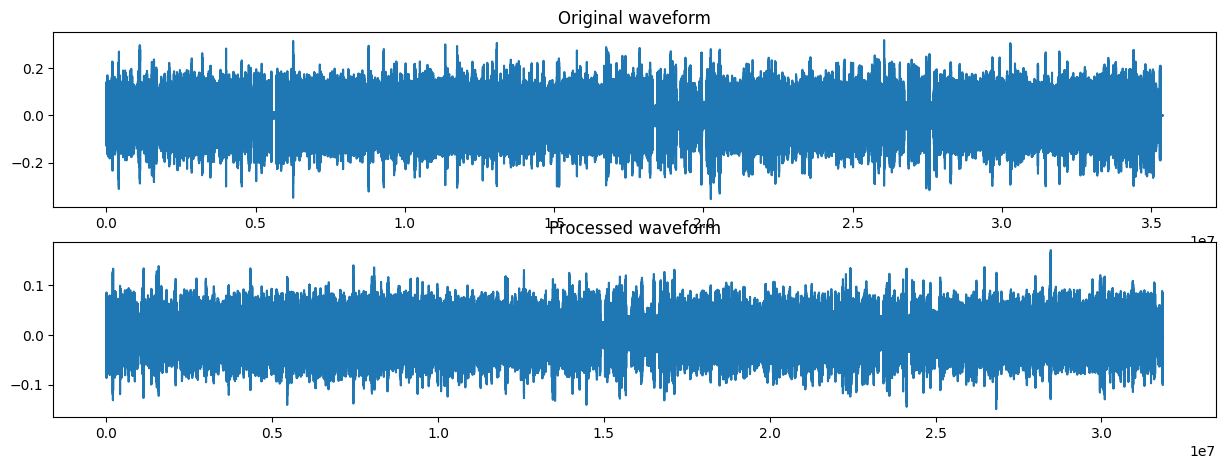

Длина после загрузки: 1604.82 сек
Длина после обрезки: 1444.63 сек
Длина после обработки: 1444.63 сек
Сегмент 0: длина 3.00 сек (требуется 1.50 сек)


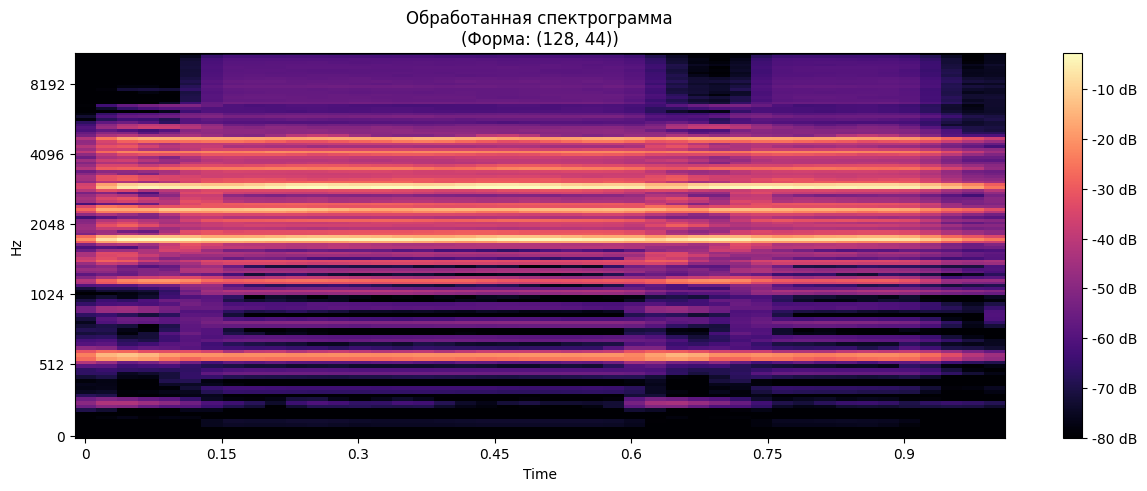

Сегмент 0: p=0.9031
Сегмент 0: p=0.9031 (явная скрипка)
Сегмент 1: длина 3.00 сек (требуется 1.50 сек)
Сегмент 1: p=0.8740
Сегмент 1: p=0.8740 (сомнительный)
Сегмент 2: длина 3.00 сек (требуется 1.50 сек)
Сегмент 2: p=0.5949
Сегмент 2: p=0.5949 (сомнительный)
Сегмент 3: длина 3.00 сек (требуется 1.50 сек)
Сегмент 3: p=0.9699
Сегмент 3: p=0.9699 (явная скрипка)
Сегмент 4: длина 3.00 сек (требуется 1.50 сек)
Сегмент 4: p=0.9392
Сегмент 4: p=0.9392 (явная скрипка)
Сегмент 5: длина 3.00 сек (требуется 1.50 сек)
Сегмент 5: p=0.9232
Сегмент 5: p=0.9232 (явная скрипка)
Сегмент 6: длина 3.00 сек (требуется 1.50 сек)
Сегмент 6: p=0.6330
Сегмент 6: p=0.6330 (сомнительный)
Сегмент 7: длина 3.00 сек (требуется 1.50 сек)
Сегмент 7: p=0.9391
Сегмент 7: p=0.9391 (явная скрипка)
Сегмент 8: длина 3.00 сек (требуется 1.50 сек)
Сегмент 8: p=0.6376
Сегмент 8: p=0.6376 (сомнительный)
Сегмент 9: длина 3.00 сек (требуется 1.50 сек)
Сегмент 9: p=0.7478
Сегмент 9: p=0.7478 (сомнительный)
Сегмент 10: длина 3.00

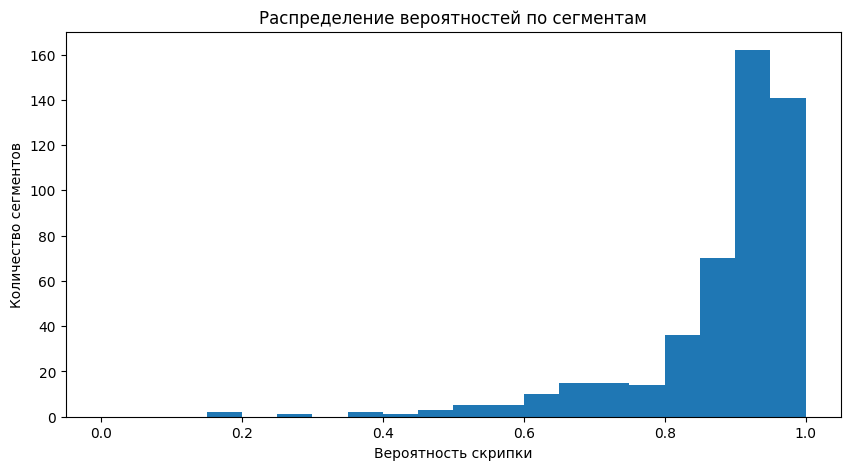

In [33]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import soundfile as sf

def debug_predict(file_path, model, segment_duration=3.0, target_time_steps=44):
    # Загрузка аудио
    y, sr = librosa.load(file_path, sr=22050, mono=True)
    
    y_trimmed = librosa.effects.split(y, top_db=25, frame_length=2048, hop_length=512)  # Делим на ненулевые участки
    y_trimmed = np.concatenate([y[start:end] for (start, end) in y_trimmed])
    
    # Альтернативное шумоподавление (если noisereduce не работает)
    # 1. Обрезка тишины
    # y_trimmed, _ = librosa.effects.trim(y, top_db=30)
    
    # 2. Медианный фильтр для подавления шумов
    y_clean = librosa.effects.preemphasis(y_trimmed, coef=0.97)
    
    # 3. Спектральное шумоподавление
    S = librosa.stft(y_clean)
    S_mag = np.abs(S)
    mask = librosa.util.softmask(S_mag, 0.2 * S_mag, power=2)
    S_clean = S * mask
    y_processed = librosa.istft(S_clean)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(2, 1, 1)
    plt.plot(y)
    plt.title("Original waveform")
    plt.subplot(2, 1, 2)
    plt.plot(y_processed)
    plt.title("Processed waveform")
    plt.show()
    
    print(f"Длина после загрузки: {len(y)/sr:.2f} сек")
    print(f"Длина после обрезки: {len(y_trimmed)/sr:.2f} сек")
    print(f"Длина после обработки: {len(y_processed)/sr:.2f} сек")
    
    # Остальной код остается без изменений...
    segment_samples = int(segment_duration * sr)
    predictions = []
    
    for i, start in enumerate(range(0, len(y_processed), segment_samples)):
        segment = y_processed[start:start+segment_samples]
        print(f"Сегмент {i}: длина {len(segment)/sr:.2f} сек (требуется {segment_duration/2:.2f} сек)")
        if len(segment) < segment_samples//2:
            print("Пропуск сегмента - слишком короткий")
            continue
            
        hop_length = max(1, len(segment) // (target_time_steps - 1))
        S = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128,
                                         hop_length=512, n_fft=2048)
        S_db = librosa.power_to_db(S, ref=np.max)
        
        if S_db.shape[1] != target_time_steps:
            S_db = librosa.util.fix_length(S_db, size=target_time_steps, axis=1)
        
        if i == 0:
            plt.figure(figsize=(15, 5))
            librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Обработанная спектрограмма\n(Форма: {S_db.shape})")
            plt.show()
        
        # После создания спектрограммы
        # print(f"\nПроверка спектрограммы для {file_path}:")
        # print("Min:", S_db.min(), "Max:", S_db.max(), "Mean:", S_db.mean())
        # plt.figure(figsize=(10, 4))
        # librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
        # plt.colorbar()
        # plt.show()
        
        S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-10)
        input_data = S_norm[np.newaxis, ..., np.newaxis]
        
        pred = model.predict(input_data, verbose=0)[0][0]
        predictions.append(pred)
        
        print(f"Сегмент {i}: p={pred:.4f}")
        
        if 0.1 < pred < 0.9:
            print(f"Сегмент {i}: p={pred:.4f} (сомнительный)")
        elif pred >= 0.9:
            print(f"Сегмент {i}: p={pred:.4f} (явная скрипка)")
            
        # if pred > 0.7 or pred < 0.3:  # Подозрительные сегменты
        #     plot_segment(segment, sr, f"Сегмент {i}: p={pred:.4f}")
    
    avg_pred = np.mean(predictions) if predictions else 0.0
    return predictions, avg_pred

# def plot_segment(y_segment, sr, title):
#     S = librosa.feature.melspectrogram(y=y_segment, sr=sr)
#     S_db = librosa.power_to_db(S, ref=np.max)
    
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
#     plt.colorbar(format='%+2.0f dB')
#     plt.title(title)
    
#     plt.subplot(1, 2, 2)
#     plt.plot(y_segment)
#     plt.title("Waveform")
#     plt.tight_layout()
#     plt.show()

# Пример использования
if __name__ == "__main__":
    # file_path = 'lettersabc/a/balanced_instruments/wav/muse_score/Скрипка_1.wav'
    file_path = 'lettersabc/a/balanced_instruments/wav/muse_score/Кларнет_1.wav'
    # file_path = 'lettersabc/a/balanced_instruments/wav/muse_score/Банджо_1.wav'
    # file_path = 'whispered-dreams-20240601-041419.wav'
    # file_path = 'Violin_for_test1.wav'
    # file_path = 'krasivaya-i-krasivaya-fortepiannaya-muzyika-40481.wav'
    # file_path = 'rahmaninov._prelyudiya_do-diez_minor.wav'
    # file_path = '526047d4315ba6b.wav'
    
    try:
        model = load_model('output/violin_model.h5')
        print("Модель успешно загружена")
        
        # Проверка файла
        info = sf.info(file_path)
        print(f"\nИнформация о файле:")
        print(f"Формат: {'стерео' if info.channels > 1 else 'моно'}")
        print(f"Частота: {info.samplerate} Hz")
        print(f"Длительность: {info.duration:.2f} сек")
        
        print("\nОбработка файла...")
        predictions, avg_pred = debug_predict(file_path, model)
        
        print("\nРезультаты:")
        print(f"Всего сегментов: {len(predictions)}")
        print(f"Средняя вероятность: {avg_pred:.4f}")
        print(f"Итоговый класс: {'violin' if avg_pred > 0.5 else 'other'}")
        
        # Визуализация распределения вероятностей
        plt.figure(figsize=(10, 5))
        plt.hist(predictions, bins=20, range=(0, 1))
        plt.title("Распределение вероятностей по сегментам")
        plt.xlabel("Вероятность скрипки")
        plt.ylabel("Количество сегментов")
        plt.show()
        
    except Exception as e:
        print(f"Ошибка: {str(e)}")